## Pre-processing

In [12]:
def read_data(path):
    with open(path, "r") as data:
        lines = data.read().splitlines()
    return lines

def fixed_length_chunks(string, length, overlap=False):
    step = 1 if overlap else length
    max_step = max(len(string) - length + 1, 1) if overlap else len(string)
    chunks = list( (string[i:length+i] for i in range(0, max_step, step)) )
    if not overlap:
        last_chunk_length_diff = length - len(chunks[-1])
        # force last chunk to be fixed length by adding a part from the penultimate chunk
        if len(chunks) > 1 and last_chunk_length_diff != 0:
            chunks[-1] = (chunks[-2] + chunks[-1])[-length:]
    return chunks

In [2]:
# Methods for training data

def remove_duplicates(chunks):
    """Removes duplicate chunks (use only for training data)."""
    duplicates = set()
    output = []
    for chunk in chunks:
        if chunk not in duplicates:
            duplicates.add(chunk)
            output.append(chunk)
    return output

def process_train_sequences(sequences, chunk_length, overlap):
    chunked_sequences = [fixed_length_chunks(seq, chunk_length, overlap) for seq in sequences]
    chunks = [chunk for chunks in chunked_sequences for chunk in chunks]
    return remove_duplicates(chunks)    

def write_train_data(chunks, out_dir):
    with open(out_dir, "w") as train:
        train.write('\n'.join(chunks))

In [3]:
# Methods for test data

def read_test_and_labels(path_no_ext):
    test = read_data(path_no_ext + ".test")
    labels = read_data(path_no_ext + ".labels")
    return test, labels

def process_test_sequences(labeled_sequences, chunk_length, overlap):
    chunked_sequences = [list( map(lambda x: (x, label), 
                                   fixed_length_chunks(seq, chunk_length, overlap)) 
                             )
                         for seq, label in labeled_sequences]
    chunks = [chunk for chunks in chunked_sequences for chunk in chunks]
    return chunks

def write_test_data(labeled_chunks, out_dir_no_ext):
    chunks = [chunk for chunk, _ in labeled_chunks]
    lbls = [label for _, label in labeled_chunks]
    with open(out_dir_no_ext + ".test", "w") as test, open(out_dir_no_ext + ".labels", "w") as labels:
        test.write('\n'.join(chunks))
        labels.write('\n'.join(lbls))

In [4]:
# Constants
CERT = "negative-selection/syscalls/snd-cert/"
UNM = "negative-selection/syscalls/snd-unm/"
OUT = "syscalls-classification/"
CHUNK_LENGTH = 7 # max 7 because that is the smallest sequence length in the data

In [5]:
def preprocess_train_data(chunk_length, overlap):
    # snd-cert
    train_cert = read_data(CERT + "snd-cert.train")
    chunks_cert = process_train_sequences(train_cert, chunk_length, overlap)
    write_train_data(chunks_cert, OUT + "snd-cert/snd-cert.train")
    # snd-unm
    train_unm = read_data(UNM+ "snd-unm.train")
    chunks_unm = process_train_sequences(train_unm, chunk_length, overlap)
    write_train_data(chunks_unm, OUT + "snd-unm/snd-unm.train")
    
def preprocess_test_data(chunk_length, overlap):
    for i in range(1, 4):
        # snd-cert
        test_cert, labels_cert = read_test_and_labels(CERT + f"snd-cert.{i}")
        labeled_chunks_cert = process_test_sequences(zip(test_cert, labels_cert), chunk_length, overlap)
        write_test_data(labeled_chunks_cert, OUT + f"snd-cert/snd-cert.{i}")
        # snd-unm
        test_unm, labels_unm = read_test_and_labels(UNM + f"snd-unm.{i}")
        labeled_chunks_unm = process_test_sequences(zip(test_unm, labels_unm), chunk_length, overlap)
        write_test_data(labeled_chunks_unm, OUT + f"snd-unm/snd-unm.{i}")

In [6]:
preprocess_train_data(CHUNK_LENGTH, overlap=False)

In [7]:
preprocess_test_data(CHUNK_LENGTH, overlap=False)

## Classification

### TO-DO: use all test files (cert and unm) + experiment with different $n$ (chunk size) and $r$

*Note: max chunk size must be 7 (i.e., only test up $n$ up to 7 and not higher) because the smallest sequence in the data is of length 7 (any higher would mean the chunks cannot be fixed length).*

In [5]:
import math
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt

In [6]:
def get_AUC(anomaly_labels, anomaly_scores):
    """Compute AUC from labels and predictions (scores)."""
    fpr, tpr, thresholds = metrics.roc_curve(anomaly_labels, anomaly_scores, pos_label=1)
    return metrics.auc(fpr, tpr)

def plot_ROC(fpr, tpr, title="", filename=None):
    """Plot ROC with its AUC."""
    auc = metrics.auc(fpr, tpr)
    plt.figure(figsize=(6, 6))
    plt.plot([0, 1], '--')
    plt.plot(fpr, tpr, label=f"AUC={auc:.2f}")
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve ' + title)
    plt.legend()
    if filename:
        plt.savefig(f'figures/{filename}')
    plt.show()

In [30]:
# basic example with snd-cert1.test
# to test every file make a loop that loops through every test file
# possibly make a loop to test different r as well
cert_data_path = OUT + "snd-cert/"
jar = f"-jar negative-selection/negsel2.jar"
alpha = f"-alphabet file://{CERT}snd-cert.alpha"
self = f"-self {cert_data_path}snd-cert.train"
params = f"-n {CHUNK_LENGTH} -r 3 -c -l"
test = f"{cert_data_path}snd-cert.1.test"

# can also pipe the output to a file with, e.g.,:
# output = cert_data_path + "snd-cert.1-out.txt"
# !java {jar} {alpha} {self} {params} < {test} > {output}
output = !java {jar} {alpha} {self} {params} < {test}

In [31]:
# string to float
counts = [float(count) for count in output]

In [32]:
# read labels and convert to float
labels = read_data(cert_data_path + "snd-cert.1.labels")
labels = [float(label) for label in labels]

AUC: 0.7129760031610067


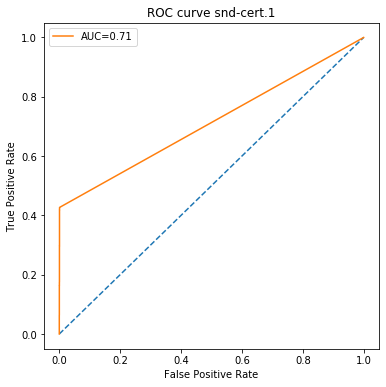

In [33]:
fpr, tpr, thresholds = metrics.roc_curve(labels, counts, pos_label=1)

# Only AUC
print("AUC:", get_AUC(labels, counts))
# or plot ROC with AUC
plot_ROC(fpr, tpr, "snd-cert.1")